## Projet Commodities

**BOISDUR William, BERGERON Arthur, CONGNARD Thomas**

The aim of this project is to create a strategie with the futures of an underlying.
We chose Natural Gas.

## Librairies

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

## Récupération des données

In [2]:
chemin = "Data_Commodities.xlsx"
data = pd.read_excel(chemin,header=1)
data=data.dropna()
data=data.iloc[:,:3]
data

,Date,BCOMNG6 Index,BCOMNG3 Index
0,2013-01-02,24.7652,35.9070
1,2013-01-03,24.5039,35.4460
2,2013-01-04,25.0831,36.3788
3,2013-01-07,24.9559,36.1751
4,2013-01-08,24.6804,35.7033
...,...,...,...
2758,2023-12-14,17.4450,12.9701
2759,2023-12-15,17.7639,13.2443
2760,2023-12-18,17.6338,13.1017
2761,2023-12-19,16.9568,12.6575


## Création du dataframe et graphiques des cours des futurs

In [3]:
df=pd.DataFrame(index=data['Date'],columns=['Natural Gas 3m','Natural Gas 6m'])

df['Natural Gas 3m']=data['BCOMNG3 Index'].values
df['Natural Gas 6m']=data['BCOMNG6 Index'].values

df

,Natural Gas 3m,Natural Gas 6m
Date,,
2013-01-02,35.9070,24.7652
2013-01-03,35.4460,24.5039
2013-01-04,36.3788,25.0831
2013-01-07,36.1751,24.9559
2013-01-08,35.7033,24.6804
...,...,...
2023-12-14,12.9701,17.4450
2023-12-15,13.2443,17.7639
2023-12-18,13.1017,17.6338


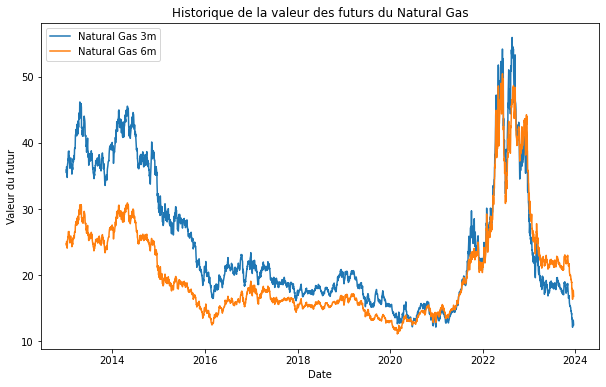

In [4]:
plt.figure(figsize=(10,6))
plt.plot(df['Natural Gas 3m'])
plt.plot(df['Natural Gas 6m'])

plt.title('Historique de la valeur des futurs du Natural Gas')
plt.legend(['Natural Gas 3m','Natural Gas 6m'])
plt.xlabel('Date')
plt.ylabel('Valeur du futur')

plt.show()

**Calcul des rendements quotidiens**

In [5]:
dfr=df.pct_change()
dfr=dfr.dropna()
dfcum=dfr.cumsum()
dfcum

,Natural Gas 3m,Natural Gas 6m
Date,,
2013-01-03,-0.012839,-0.010551
2013-01-04,0.013477,0.013086
2013-01-07,0.007878,0.008015
2013-01-08,-0.005164,-0.003025
2013-01-09,-0.031431,-0.027064
...,...,...
2023-12-14,-0.290659,0.122930
2023-12-15,-0.269518,0.141210
2023-12-18,-0.280285,0.133886


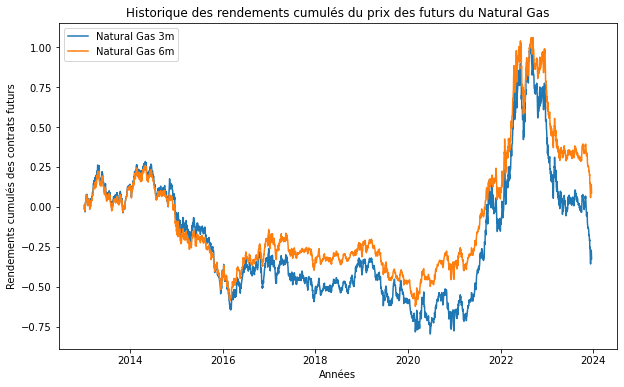

In [6]:
plt.figure(figsize=(10,6))
plt.plot(dfcum.iloc[:,:2])
plt.legend(dfcum.iloc[:,:2].columns)

plt.title('Historique des rendements cumulés du prix des futurs du Natural Gas')
plt.ylabel("Rendements cumulés des contrats futurs")
plt.xlabel("Années")
plt.show()

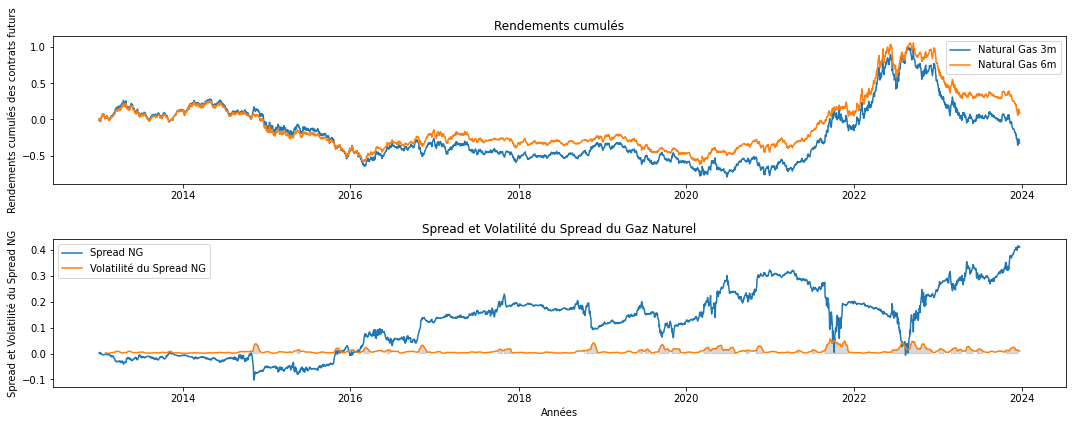

In [7]:
# Calcul du spread
dfcum['Spread_NG'] = dfcum['Natural Gas 6m'] - dfcum['Natural Gas 3m']

# Calcul de la volatilité du spread
window_size = 20  # Exemple : fenêtre de 20 jours
dfcum['Spread_Volatility'] = dfcum['Spread_NG'].rolling(window=window_size).std()

# Seuil de volatilité pour prendre une position
volatility_threshold = dfcum['Spread_Volatility'].quantile(0.75)  # Exemple : 75ème percentile

# Définir les positions (True pour prendre une position, False sinon)
dfcum['Position'] = dfcum['Spread_Volatility'] > volatility_threshold

# Visualisation
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(dfcum[['Natural Gas 3m', 'Natural Gas 6m']])
plt.legend(['Natural Gas 3m', 'Natural Gas 6m'])
plt.ylabel("Rendements cumulés des contrats futurs")
plt.title("Rendements cumulés")

plt.subplot(2, 1, 2)
plt.plot(dfcum['Spread_NG'], label='Spread NG')
plt.plot(dfcum['Spread_Volatility'], label='Volatilité du Spread NG')
plt.fill_between(dfcum.index, 0, dfcum['Spread_Volatility'], where=dfcum['Position'], color='gray', alpha=0.3)
plt.legend()
plt.ylabel("Spread et Volatilité du Spread NG")
plt.title("Spread et Volatilité du Spread du Gaz Naturel")

plt.xlabel("Années")
plt.tight_layout()
plt.show()

## Stratégie Natural Gas

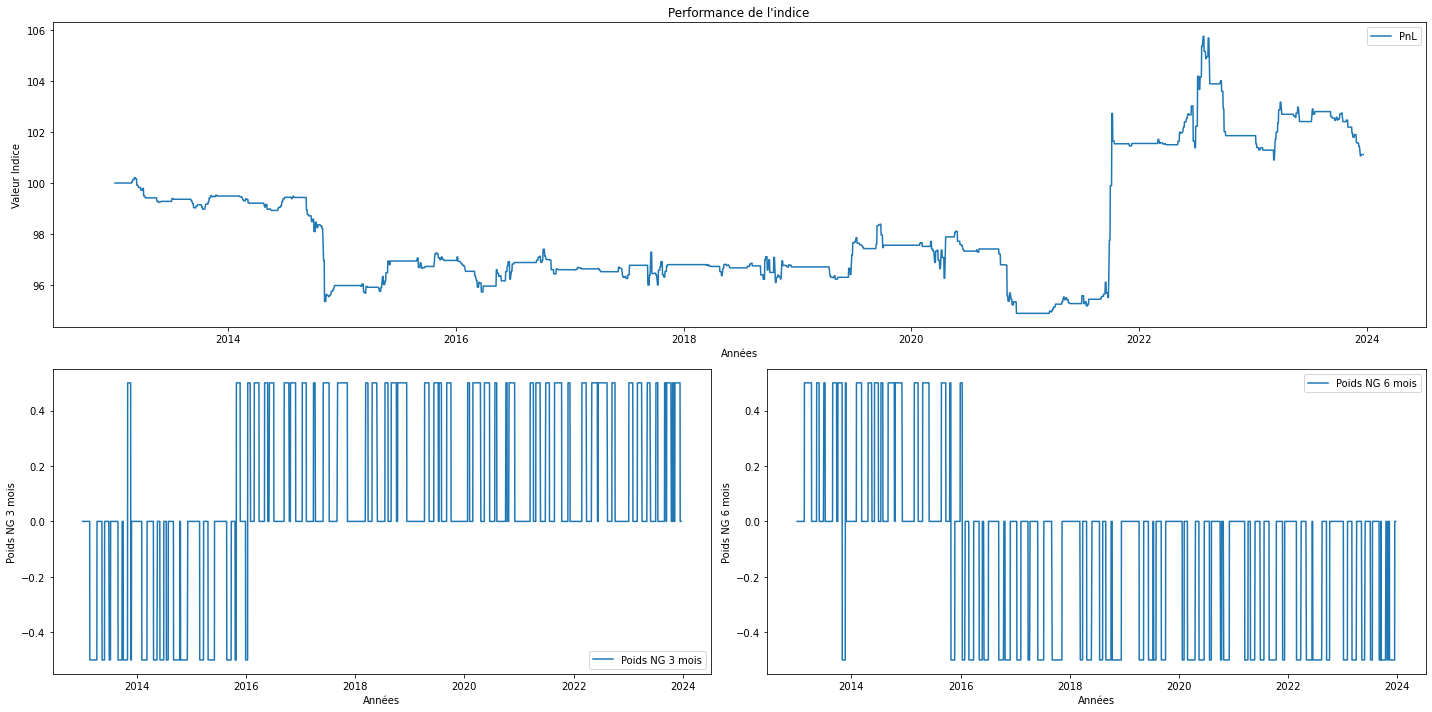

In [8]:

Historique_NG = pd.DataFrame(index=dfcum.index, columns=['PnL', 'Poids_NG_3m', 'Poids_NG_6m'])

Rebalancing_period = 3  # Période de rééquilibrage en jours
Expo_NG_max = 100
PnL = Expo_NG_max
Poids_NG_6m = 0
Poids_NG_3m = 0

window_size = 30  # Taille de la fenêtre pour le calcul de la volatilité du spread
volatility_threshold_percentile = 0.6  # Seuil de volatilité (75ème percentile)

# Calcul de la volatilité du spread sur toute la période
dfcum['Spread_Volatility'] = dfcum['Spread_NG'].rolling(window=window_size).std()

for jour in range(0, len(dfcum.index), Rebalancing_period):
    PnL += (Poids_NG_6m * dfr['Natural Gas 6m'].iloc[jour] + Poids_NG_3m * dfr['Natural Gas 3m'].iloc[jour]) * Expo_NG_max
    Historique_NG['PnL'].iloc[jour] = PnL
    
    # Utilisation de la volatilité du spread pour ajuster les poids
    if jour >= window_size:
        current_volatility = dfcum['Spread_Volatility'].iloc[jour]
        volatility_threshold = dfcum['Spread_Volatility'].iloc[max(0, jour - window_size):jour].quantile(volatility_threshold_percentile)
    else:
        current_volatility = float('inf')  # Pour les premières périodes, on ne prend pas de position
        volatility_threshold = float('inf')

    if current_volatility > volatility_threshold:
        spread = dfcum['Natural Gas 6m'].iloc[jour] - dfcum['Natural Gas 3m'].iloc[jour]
        if spread >= 0:
            Poids_NG_6m = -0.5
            Poids_NG_3m = 0.5
        else:
            Poids_NG_6m = 0.5
            Poids_NG_3m = -0.5
    else:
        Poids_NG_6m = 0  # Pas de position si la volatilité est basse
        Poids_NG_3m = 0

    Historique_NG['Poids_NG_6m'].iloc[jour] = Poids_NG_6m
    Historique_NG['Poids_NG_3m'].iloc[jour] = Poids_NG_3m

Historique_NG = Historique_NG.fillna(method='ffill')  # Remplir les valeurs manquantes par propagation
Historique_NG.index = pd.to_datetime(Historique_NG.index)

# Visualisation des résultats
plt.figure(figsize=(20, 10))

# Tracé du PnL
plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, position 1
plt.plot(Historique_NG['PnL'], label='PnL')
plt.ylabel("Valeur Indice")
plt.xlabel("Années")
plt.legend()
plt.title("Performance de l'indice")

# Tracé des poids
plt.subplot(2, 2, 3)  # 2 lignes, 2 colonnes, position 3
plt.plot(Historique_NG['Poids_NG_3m'], label='Poids NG 3 mois')
plt.ylabel("Poids NG 3 mois")
plt.xlabel("Années")
plt.legend()

plt.subplot(2, 2, 4)  # 2 lignes, 2 colonnes, position 4
plt.plot(Historique_NG['Poids_NG_6m'], label='Poids NG 6 mois')
plt.ylabel("Poids NG 6 mois")
plt.xlabel("Années")
plt.legend()

plt.tight_layout()
plt.show()

## Calcul des statistiques

In [9]:
def MDD(L):
    L_res=[]
    for i in range (1,len(L)):
        L_res.append(-(L[i]-L[i-1])/L[i-1])
    return max(L_res)

In [10]:
rdt_NG_2013=Historique_NG[Historique_NG.index.year==2013]
rdt_NG_2014=Historique_NG[Historique_NG.index.year==2014]
rdt_NG_2015=Historique_NG[Historique_NG.index.year==2015]
rdt_NG_2016=Historique_NG[Historique_NG.index.year==2016]
rdt_NG_2017=Historique_NG[Historique_NG.index.year==2017]
rdt_NG_2018=Historique_NG[Historique_NG.index.year==2018]
rdt_NG_2019=Historique_NG[Historique_NG.index.year==2019]
rdt_NG_2020=Historique_NG[Historique_NG.index.year==2020]
rdt_NG_2021=Historique_NG[Historique_NG.index.year==2021]
rdt_NG_2022=Historique_NG[Historique_NG.index.year==2022]
rdt_NG_2023=Historique_NG[Historique_NG.index.year==2023]
rdt_NG_5y=Historique_NG[Historique_NG.index.year>2018]
rdt_NG_10y=Historique_NG

Histo_NG_rdt=[rdt_NG_2013,rdt_NG_2014,rdt_NG_2015,rdt_NG_2016,rdt_NG_2017,rdt_NG_2018,rdt_NG_2019,rdt_NG_2020,rdt_NG_2021,rdt_NG_2022,rdt_NG_2023,rdt_NG_5y,rdt_NG_10y]

Annees=[i for i in range(2013,2024)]
Annees.append("5Y")
Annees.append("10Y")
res=pd.DataFrame(index=Annees,columns=['Ann. Return','Ann. Volatility','Sharpe Ratio','Max Drawdown'])

for i in range(len(Histo_NG_rdt)):
    if i<len(Histo_NG_rdt)-2:
        r=Histo_NG_rdt[i].iloc[-1,0]/Expo_NG_max-1
        vol=Histo_NG_rdt[i].iloc[:,0].std()
        res.loc[i+2013,('Ann. Return')]=str(round(r*100,3))+'%'
        res.loc[i+2013,('Ann. Volatility')]=str(round(vol,3))+'%'
        res.loc[i+2013,('Sharpe Ratio')]=str(round(r*100/vol,3))
        res.loc[i+2013,('Max Drawdown')]=str(round(MDD(Histo_NG_rdt[i].iloc[:,0])*100,3))+'%'
    elif i==len(Histo_NG_rdt)-2:
        r=(Histo_NG_rdt[i].iloc[-1,0]/Expo_NG_max)**(1/5)-1
        vol=Histo_NG_rdt[i].iloc[:,0].std()
        res.iloc[-2,0]=str(round(r*100,3))+'%'
        res.iloc[-2,1]=str(round(vol,3))+'%'
        res.iloc[-2,2]=str(round(r*100/vol,3))
        res.iloc[-2,3]=str(round(MDD(Histo_NG_rdt[i].iloc[:,0])*100,3))+'%'
    else :
        r=(Histo_NG_rdt[i].iloc[-1,0]/Expo_NG_max)**(1/10)-1
        vol=Histo_NG_rdt[i].iloc[:,0].std()
        res.iloc[-1,0]=str(round(r*100,3))+'%'
        res.iloc[-1,1]=str(round(vol,3))+'%'
        res.iloc[-1,2]=str(round(r/vol,3))
        res.iloc[-1,3]=str(round(MDD(Histo_NG_rdt[i].iloc[:,0])*100,3))+'%'

#res.to_excel("/Users/thomascgd/Desktop/Esilv/A5/Commodities/Res.xlsx",index=True)
res

,Ann. Return,Ann. Volatility,Sharpe Ratio,Max Drawdown
2013,-0.511%,0.313%,-1.634,0.296%
2014,-4.02%,1.266%,-3.176,1.655%
2015,-3.036%,0.486%,-6.252,0.386%
2016,-3.4%,0.373%,-9.126,0.705%
2017,-3.2%,0.188%,-16.984,0.862%
2018,-3.291%,0.174%,-18.965,1.013%
2019,-2.44%,0.566%,-4.31,0.51%
2020,-5.111%,0.891%,-5.733,1.248%
2021,1.551%,2.772%,0.559,1.049%
2022,1.857%,1.157%,1.605,1.703%
